# Section IV. ML-model

### Load libraries, functions, palette, theme, etc.

In [422]:
# load libraries
%run __theme.ipynb

In [423]:
# load functions
%run __functions.ipynb

In [377]:
# start stopwatch
start = stopwatch_start()

In [378]:
dir_current = '04-ml-model'

In [379]:
dir_save_files = 'files/'

In [380]:
dir_load_files = 'files/'

In [381]:
dir_save_img = 'docs/img/'

In [382]:
session_name = dir_current

### Load libraries, functions, palette, theme

In [383]:
import os
from pathlib import Path

In [384]:
# load functions
from __functions import *

In [385]:
# load libraries and palette
%run __libraries.ipynb

In [386]:
# start stopwatch
start = stopwatch_start()

### Variables

In [387]:
dir_current = '04-ml-model'

In [388]:
dir_save_files = 'files/'

In [389]:
dir_load_files = 'files/'

In [390]:
dir_save_img = 'docs/img/'

### Load Files

##### Dictionaries

In [391]:
datasets = loadit('datasets', dir=dir_load_files)

In [392]:
variables = loadit('variables', dir=dir_load_files, create_empty_dict=True)

In [393]:
cv = loadit('cv', dir=dir_load_files, create_empty_dict=True)

##### Datasets

In [394]:
train = extract_variable('train_preprocessed', datasets)

In [395]:
valid = extract_variable('valid_preprocessed', datasets)

In [396]:
test = extract_variable('test_preprocessed', datasets)

Variable test_preprocessed not found


##### CV results

In [397]:
cv0 = extract_variable('cv0', cv)

In [398]:
cv1 = extract_variable('cv1', cv)

In [399]:
cv2 = extract_variable('cv2', cv)

In [400]:
cv3 = extract_variable('cv3', cv)

## Base ML-model

### Datasets and Variables

In [401]:
features = [
    'temperature', 'humidity', 'windspeed', 'generaldiffuseflows',
    'diffuseflows', 'minute', 'hour', 'day',
    'day_number', 'day_of_year', 'weekday', 'week', 'month',
    'count_elmnts_by_day', 'target_diff', 'target_returns',
    'target_volatility', 'p', 'minute_of_day', 'is_Friday', 'is_Sunday',
    'diff_Sunday', 'is_Day', 'is_31', 'is_20hours', 'target_cum_avg',
    'target_previous_month'
]

In [402]:
target = train['target'].copy()

In [403]:
train_ml = train[features].copy()

In [404]:
train_ml = train_ml.reset_index(names='datetime')

In [405]:
test_df = train_ml.copy()

In [406]:
cv_indexes_train, cv_indexes_eval = cv_split_indexes(
    data=train['target'], start='2017-03-01', train_size=1,
    test_size=1, size_unit='months', n_splits=5, freq='10min')

In [407]:
cv_indexes_gs_base = []
for trn, evl in zip(cv_indexes_train, cv_indexes_eval):
    trn_df = train_ml[train_ml['datetime'].isin(trn)].copy()
    trn_ev = train_ml[train_ml['datetime'].isin(evl)].copy()
    cv_indexes_gs_base.append((trn_df.index, trn_ev.index))

In [408]:
train_ml = train_ml.drop('datetime', axis=1)

In [409]:
train_ml.head()

,temperature,humidity,windspeed,generaldiffuseflows,diffuseflows,minute,hour,day,day_number,day_of_year,...,p,minute_of_day,is_Friday,is_Sunday,diff_Sunday,is_Day,is_31,is_20hours,target_cum_avg,target_previous_month
0,6.559,73.8,0.083,0.051,0.119,0,0,1,1,1,...,NaN,0.0,0,1,0.0,0,0,0,NaN,NaN
1,6.414,74.5,0.083,0.070,0.085,10,0,1,1,1,...,-0.124532,10.0,0,1,0.0,0,0,0,34055.696200,NaN
2,6.313,74.5,0.080,0.062,0.100,20,0,1,1,1,...,-0.023028,20.0,0,1,0.0,0,0,0,31935.189870,NaN
3,6.121,75.0,0.083,0.091,0.096,30,0,1,1,1,...,-0.030872,30.0,0,1,0.0,0,0,0,30999.493670,NaN
4,5.921,75.7,0.081,0.048,0.085,40,0,1,1,1,...,-0.031640,40.0,0,1,0.0,0,0,0,30306.835442,NaN


### Model

In [410]:
lgb_base = LGBMRegressor()

In [411]:
params_base = {
    # 'estimator__n_estimators':[5, 10, 25, 50, 75, 100, 150],
    'n_estimators':[5, 10],
    'max_depth':[3, 6, 9],
    'learning_rate':[0.1, 0.3],
    'random_state':[seed],
    'verbose': [-1]
}

In [412]:
gs_base = GridSearchCV(
    estimator=lgb_base,
    param_grid=params_base,
    scoring='neg_root_mean_squared_error',
    cv=cv_indexes_gs_base
)

In [413]:
gs_base.fit(train_ml, target)

GridSearchCV(cv=[(Index([4464, 4465, 4466, 4467, 4468, 4469, 4470, 4471, 4472, 4473,
       ...
       8486, 8487, 8488, 8489, 8490, 8491, 8492, 8493, 8494, 8495],
      dtype='int64', length=4032),
                  Index([ 8496,  8497,  8498,  8499,  8500,  8501,  8502,  8503,  8504,  8505,
       ...
       12950, 12951, 12952, 12953, 12954, 12955, 12956, 12957, 12958, 12959],
      dtype='int64', length=4464)),
                 (Index([ 8496,  8497,  8498,  8499,  8500,  8501,  8502,  85...
      dtype='int64', length=4320),
                  Index([26064, 26065, 26066, 26067, 26068, 26069, 26070, 26071, 26072, 26073,
       ...
       30518, 30519, 30520, 30521, 30522, 30523, 30524, 30525, 30526, 30527],
      dtype='int64', length=4464))],
             estimator=LGBMRegressor(),
             param_grid={'learning_rate': [0.1, 0.3], 'max_depth': [3, 6, 9],
                         'n_estimators': [5, 10], 'random_state': [42],
                         'verbose': [-1]},
             scoring='neg_root_mean_squared_error')

In [414]:
gs_base.best_estimator_

LGBMRegressor(learning_rate=0.3, max_depth=9, n_estimators=10, random_state=42,
              verbose=-1)

In [415]:
gs_base.best_score_

-2815.0483597291595

In [416]:
gs_base_best_results = pd.DataFrame(gs_base.cv_results_).sort_values('rank_test_score').iloc[0]

In [418]:
gs_base_best_results_splits_iloc = \
    list(np.where(pd.Series(gs_base_best_results.index).str.contains('split'))[0])

In [419]:
gs_base_best_results_splits = gs_base_best_results.T.iloc[gs_base_best_results_splits_iloc]

In [420]:
gs_base_best_results_splits = gs_base_best_results_splits.abs()

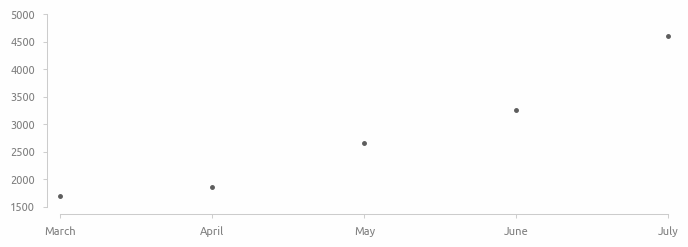

In [424]:
plt.scatter(
    x=gs_base_best_results_splits.index,
    y=gs_base_best_results_splits.values, s=25)
plt.xticks(gs_base_best_results_splits.index, months_list[2:7])
axis_rstyle()

## Save Data

### Execution time

In [27]:
stopwatch_stop(start)

Execution time: 0:00:00
